<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/evictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_formats = ["retina"]

In [3]:
!pip install -q folium scikit-learn census seaborn geopandas

In [76]:
#!curl -OL https://www2.census.gov/geo/tiger/TIGER2018/shp/COUNTY/tl_2018_us_county.zip

## Evictions

In [48]:
import census
import folium
import folium.plugins
import geopandas as gpd
import io
import us
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from census import Census
from shapely import Point

We'll start this week with data from the [Eviction Lab](https://evictionlab.org/). This data has been assembled and compiled from multiple sources by The Eviction Lab at Princeton. More information on the methods they've used can be found [here](https://evictionlab.org/methods/). It is a powerful resource for studying eviction patterns throughout the United States.

We'll start with data for estimating eviction prevalence.

In [99]:
df_eviction_prev = pd.read_csv(
    "https://eviction-lab-data-downloads.s3.amazonaws.com/estimating-eviction-prevalance-across-us/county_eviction_estimates_2000_2018.csv"
)
df_eviction_prev.head()

state          county  FIPS_state  FIPS_county  year  renting_hh  \
0  Alabama  Autauga County           1         1001  2000        3074   
1  Alabama  Autauga County           1         1001  2001        3264   
2  Alabama  Autauga County           1         1001  2002        3454   
3  Alabama  Autauga County           1         1001  2003        3644   
4  Alabama  Autauga County           1         1001  2004        3834   

   filings_estimate  filings_ci_95_lower  filings_ci_95_upper  \
0               109                  109                  109   
1                75                   75                   75   
2                94                   94                   94   
3               100                  100                  100   
4               112                  112                  112   

   ind_filings_court_issued  ind_filings_court_issued_LT  hh_threat_estimate  \
0                         1                          0.0                 106   
1                         1                          0.0                  74   
2                         1                          0.0                  92   
3                         1                          0.0                  98   
4                         1                          0.0                 110   

   hh_threat_95_lower  hh_threat_95_upper  ind_hht_observed  
0                 106                 106                 1  
1                  71                  75                 0  
2                  88                  94                 0  
3                  94                 100                 0  
4                 106                 112                 0

Next we'll calculate three measures that are common in the eviction literature and that the Eviction Lab reports:
* *Eviction filing rate:* a ratio of the total number of evictions *filed* over the number of renter-occupied homes in that area.
* *Households threatened rate:* a ratio of households who ever received an eviction filing in a given year over the number of renter-occupied homes in that area. Note: the eviction filing rate will always be higher than the households threatened rate.
* *Eviction rate:* the number of homes with an eviction judgment/court order requiring tenants to leave over all renter-occupied homes.

In [100]:
df_eviction_prev["filing_rate"] = (
    df_eviction_prev["filings_estimate"] / df_eviction_prev["renting_hh"]
)
df_eviction_prev["threatened_rate"] = (
    df_eviction_prev["hh_threat_estimate"] / df_eviction_prev["renting_hh"]
)

In [101]:
df_eviction_prev[["filing_rate", "threatened_rate"]].describe()

filing_rate  threatened_rate
count  59717.000000     59717.000000
mean       0.050107         0.041740
std        0.074730         0.046203
min        0.000000         0.000000
25%        0.013820         0.013514
50%        0.028107         0.026987
75%        0.056572         0.051903
max        1.546182         0.595697

In [107]:
df_eviction_prev_avg = df_eviction_prev.groupby("FIPS_county")[
    ["filing_rate", "threatened_rate"]
].mean()
df_eviction_prev_avg.head()

filing_rate  threatened_rate
FIPS_county                              
1001            0.028708         0.028155
1003            0.032584         0.031676
1005            0.008885         0.008885
1007            0.014606         0.014557
1009            0.015245         0.015059

In [109]:
# load counties shapefiles to map
gdf_counties = gpd.read_file("../data/tl_2018_us_county.zip")
gdf_counties.head()
gdf_counties["county_fips_full"] = (
    gdf_counties["STATEFP"] + gdf_counties["COUNTYFP"]
).astype(int)
gdf_counties.set_index("county_fips_full", inplace=True)

gdf_eviction_filings = gdf_counties.join(df_eviction_prev_avg, how="left")

In [110]:
gdf_eviction_filings.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME  \
county_fips_full                                                
31039                 31      039  00835841  31039     Cuming   
53069                 53      069  01513275  53069  Wahkiakum   
35011                 35      011  00933054  35011    De Baca   
31109                 31      109  00835876  31109  Lancaster   
31129                 31      129  00835886  31129   Nuckolls   

                          NAMELSAD LSAD CLASSFP  MTFCC CSAFP CBSAFP METDIVFP  \
county_fips_full                                                               
31039                Cuming County   06      H1  G4020  None   None     None   
53069             Wahkiakum County   06      H1  G4020  None   None     None   
35011               De Baca County   06      H1  G4020  None   None     None   
31109             Lancaster County   06      H1  G4020   339  30700     None   
31129              Nuckolls County   06      H1  G4020  None   None     None   

                 FUNCSTAT       ALAND    AWATER     INTPTLAT      INTPTLON  \
county_fips_full                                                             
31039                   A  1477652222  10690952  +41.9158651  -096.7885168   
53069                   A   680956809  61588406  +46.2946377  -123.4244583   
35011                   A  6016819484  29089486  +34.3592729  -104.3686961   
31109                   A  2169287528  22832516  +40.7835474  -096.6886584   
31129                   A  1489645187   1718484  +40.1764918  -098.0468422   

                                                           geometry  \
county_fips_full                                                      
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...   
53069             POLYGON ((-123.43639 46.2382, -123.44759 46.24...   
35011             POLYGON ((-104.56739 33.99757, -104.56772 33.9...   
31109             POLYGON ((-96.91075 40.78494, -96.91075 40.790...   
31129             POLYGON ((-98.27367 40.0894, -98.27367 40.0894...   

                  filing_rate  threatened_rate  
county_fips_full                                
31039                0.003793         0.003793  
53069                0.011447         0.010972  
35011                0.008701         0.008701  
31109                0.038422         0.035843  
31129                0.003212         0.003116

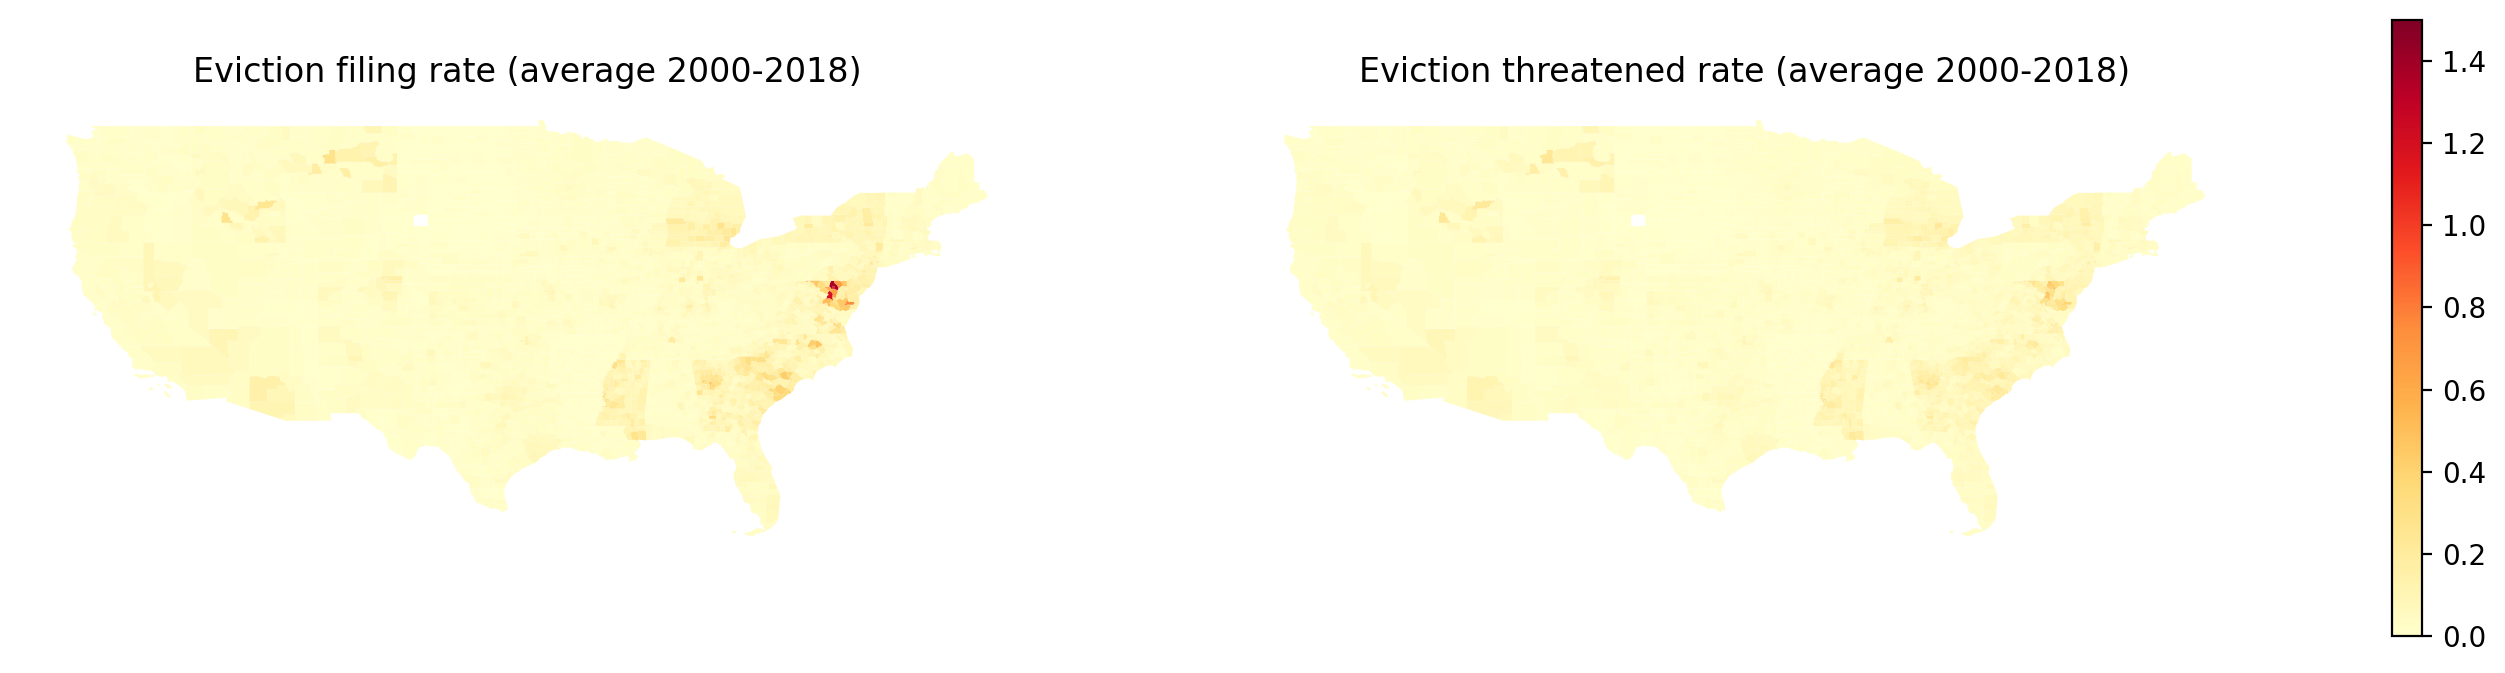

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# filter out hawaii and alaska for visualization
state_filter = ~gdf_eviction_filings.STATEFP.isin(["15", "02"])
gdf_eviction_filings[state_filter].plot(
    column="filing_rate", ax=axes[0], vmin=0, vmax=1.5, cmap="YlOrRd", legend=False
)
gdf_eviction_filings[state_filter].plot(
    column="threatened_rate", ax=axes[1], vmin=0, vmax=1.5, cmap="YlOrRd", legend=False
)
axes[0].set_title("Eviction filing rate (average 2000-2018)")
axes[1].set_title("Eviction threatened rate (average 2000-2018)")
axes[0].set_axis_off()
axes[1].set_axis_off()

# assume it's the first (and only) mappable
patch_col = axes[0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

Now we'll explore the proprietary data. Note: many of these rates have already been produced without denominators, so we won't have to create them ourselves.

In [117]:
df_proprietary = pd.read_csv(
    "https://eviction-lab-data-downloads.s3.amazonaws.com/estimating-eviction-prevalance-across-us/county_proprietary_2000_2018.csv"
)
df_proprietary.head()

In [122]:
df_proprietary_avg = df_proprietary.groupby(["id"])[
    ["filing_rate", "threatened_rate", "judgement_rate"]
].mean()
df_proprietary_avg.head()

filing_rate  threatened_rate  judgement_rate
id                                                
1001     2.351053         2.228421        1.226316
1003     3.085789         2.992632        1.646842
1005     0.781053         0.770000        0.416316
1007     0.995789         0.979474        0.537895
1009     1.448947         1.424737        1.033158

In [124]:
gdf_proprietary_filings = gdf_counties.join(df_proprietary_avg, how="left")

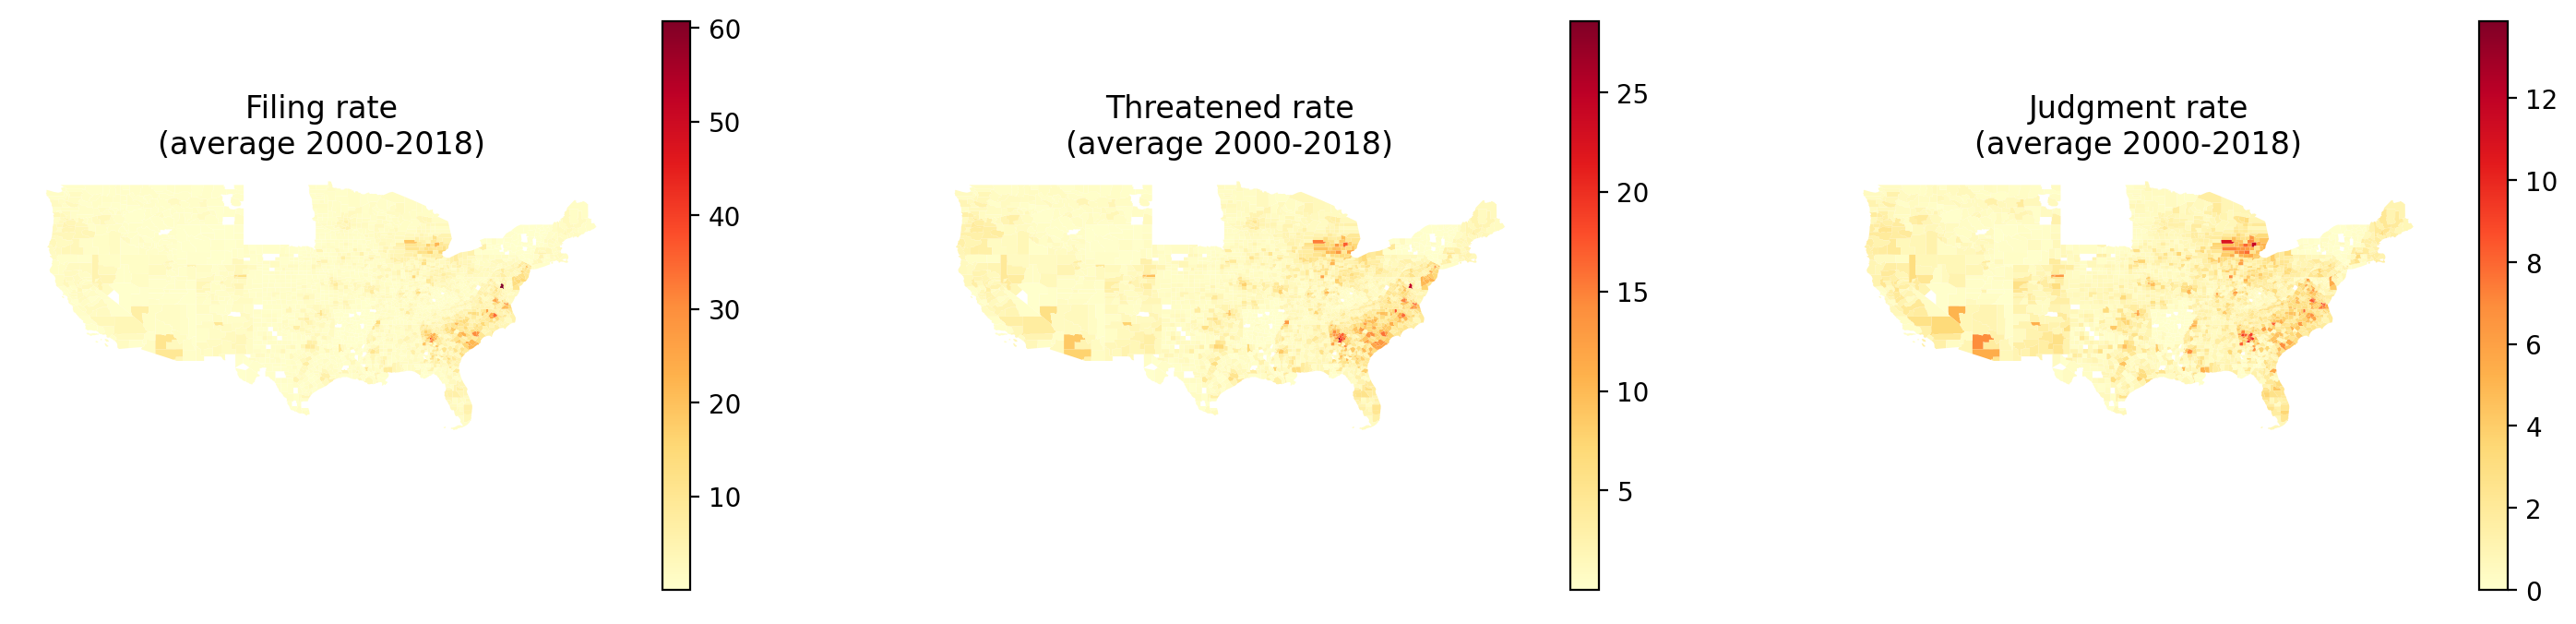

In [141]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
# filter out hawaii and alaska for visualization
state_filter = ~gdf_proprietary_filings.STATEFP.isin(["15", "02"])
gdf_proprietary_filings[state_filter].plot(
    column="filing_rate",
    ax=axes[0],
    cmap="YlOrRd",
    legend=True,
    legend_kwds={"shrink": 0.5},
)
gdf_proprietary_filings[state_filter].plot(
    column="threatened_rate",
    ax=axes[1],
    cmap="YlOrRd",
    legend=True,
    legend_kwds={"shrink": 0.5},
)
gdf_proprietary_filings[state_filter].plot(
    column="judgement_rate",
    ax=axes[2],
    cmap="YlOrRd",
    legend=True,
    legend_kwds={"shrink": 0.5},
)

axes[0].set_title("Filing rate\n(average 2000-2018)")
axes[1].set_title("Threatened rate\n(average 2000-2018)")
axes[2].set_title("Judgment rate\n(average 2000-2018)")
axes[0].set_axis_off()
axes[1].set_axis_off()
axes[2].set_axis_off()

## Eviction Data: NYC Open Data

In [151]:
mppluto = gpd.read_file("../data/nyc_mappluto_25v1_fgdb/MapPLUTO25v1.gdb")
mppluto.head()

/opt/anaconda3/envs/pubpol2130/lib/python3.13/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'MapPLUTO25v1.gdb': 'MapPLUTO_25v1_clipped' (default), 'NOT_MAPPED_LOTS'. Specify layer parameter to avoid this warning.
  result = read_func(


Borough  Block  Lot     CD  BCT2020    BCTCB2020 CT2010 CB2010 SchoolDist  \
0      MN      3    4  101.0  1031900  10319001000    319   1000         02   
1      MN      1  111  101.0  1000500  10005001003      5   1000         02   
2      MN      1  201  101.0  1000100  10001001000      1   1000         02   
3      MN      2    1  101.0  1000900  10009001022      9   1025         02   
4      MN      2    2  101.0  1000900  10009001022      9   1025         02   

   Council  ...  FIRM07_FLAG PFIRM15_FLAG  Version  DCPEdited   Latitude  \
0      1.0  ...            1            1     25v1       None  40.701255   
1      1.0  ...            1            1     25v1       None  40.692922   
2      1.0  ...         None            1     25v1       None  40.698188   
3      1.0  ...            1            1     25v1          t  40.700369   
4      1.0  ...            1            1     25v1       None  40.700550   

   Longitude Notes Shape_Leng    Shape_Area  \
0 -74.013939  None        0.0  2.777325e+03   
1 -74.017637  None        0.0  6.445096e+04   
2 -74.041329  None        0.0  1.148539e+06   
3 -74.012911  None        0.0  1.008250e+05   
4 -74.011588  None        0.0  8.724419e+04   

                                            geometry  
0  MULTIPOLYGON (((980403.205 194731.754, 980403....  
1  MULTIPOLYGON (((979185.332 191646.482, 979184....  
2  MULTIPOLYGON (((973648.066 193711.894, 973525....  
3  MULTIPOLYGON (((980609.55 194220.422, 980608.7...  
4  MULTIPOLYGON (((980854.138 194531.437, 980823....  

[5 rows x 95 columns]

In [154]:
mppluto.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCenterDistrict', 'HealthArea', 'Sanitboro', 'SanitDistrict',
       'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3',
       'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3',
       'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse', 'Easements',
       'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea',
       'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea',
       'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext',
       'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand',
       'AssessTot', 'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2',
       'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR',
       'BoroCode', 'BBL', 'Cond

In [ ]:
df_nyc_evictions = pd.read_csv(
    "https://data.cityofnewyork.us/resource/6z8x-wfk4.csv?$limit=100000"
)

In [177]:
nyc_evictions_pluto = mppluto[
    [
        "BBL",
        "OwnerType",
        "LandUse",
        "UnitsTotal",
        "UnitsRes",
        "AssessLand",
        "AssessTot",
        "ExemptTot",
        "YearBuilt",
        "geometry",
    ]
].merge(df_nyc_evictions, left_on="BBL", right_on="bbl")

In [178]:
nyc_evictions_pluto.head()

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0  1.000078e+09      None      04        43.0      42.0   1741500.0   
1  1.000078e+09      None      04        43.0      42.0   1741500.0   
2  1.000100e+09      None      05        97.0       0.0   6930000.0   
3  1.000118e+09      None      04         4.0       3.0    363150.0   
4  1.000200e+09      None      05        71.0       0.0  11340000.0   

    AssessTot  ExemptTot  YearBuilt  \
0   6970950.0        0.0     1880.0   
1   6970950.0        0.0     1880.0   
2  30483900.0        0.0     1930.0   
3   3464190.0        0.0     1900.0   
4  32468850.0        0.0     1983.0   

                                            geometry  ...         ejectment  \
0  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...  Not an Ejectment   
1  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...  Not an Ejectment   
2  MULTIPOLYGON (((980867.809 195627.081, 980872....  ...  Not an Ejectment   
3  MULTIPOLYGON (((980911.184 195813.831, 980911....  ...  Not an Ejectment   
4  MULTIPOLYGON (((980678.427 196676.025, 980634....  ...  Not an Ejectment   

   eviction_possession   latitude  longitude community_board council_district  \
0           Possession  40.703611 -74.010932             1.0              1.0   
1           Possession  40.703611 -74.010932             1.0              1.0   
2           Possession  40.703954 -74.011592             1.0              1.0   
3           Possession  40.704034 -74.012068             1.0              1.0   
4           Possession  40.706397 -74.012829             1.0              1.0   

  census_tract        bin           bbl                                nta  
0          9.0  1077806.0  1.000078e+09  Battery Park City-Lower Manhattan  
1          9.0  1077806.0  1.000078e+09  Battery Park City-Lower Manhattan  
2          9.0  1000025.0  1.000100e+09  Battery Park City-Lower Manhattan  
3          9.0  1000040.0  1.000118e+09  Battery Park City-Lower Manhattan  
4         13.0  1000804.0  1.000200e+09  Battery Park City-Lower Manhattan  

[5 rows x 30 columns]

In [226]:
# create a version that's point data
nyc_evictions_pluto_centroid = nyc_evictions_pluto.copy()
nyc_evictions_pluto_centroid["geometry"] = nyc_evictions_pluto_centroid[
    "geometry"
].centroid

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boros = gpd.read_file(
    "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"
).to_crs(2263)
boros.plot(ax=ax, facecolor="none")
nyc_evictions_pluto.plot(ax=ax)
ax.set_axis_off()

In [181]:
building_eviction_count = (
    nyc_evictions_pluto.value_counts("BBL")
    .reset_index()
    .rename(columns={"count": "total_num_evictions"})
)
nyc_evictions_pluto = nyc_evictions_pluto.merge(building_eviction_count, on="BBL")
nyc_evictions_pluto.head()

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0  1.000078e+09      None      04        43.0      42.0   1741500.0   
1  1.000078e+09      None      04        43.0      42.0   1741500.0   
2  1.000100e+09      None      05        97.0       0.0   6930000.0   
3  1.000118e+09      None      04         4.0       3.0    363150.0   
4  1.000200e+09      None      05        71.0       0.0  11340000.0   

    AssessTot  ExemptTot  YearBuilt  \
0   6970950.0        0.0     1880.0   
1   6970950.0        0.0     1880.0   
2  30483900.0        0.0     1930.0   
3   3464190.0        0.0     1900.0   
4  32468850.0        0.0     1983.0   

                                            geometry  ... eviction_possession  \
0  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...          Possession   
1  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...          Possession   
2  MULTIPOLYGON (((980867.809 195627.081, 980872....  ...          Possession   
3  MULTIPOLYGON (((980911.184 195813.831, 980911....  ...          Possession   
4  MULTIPOLYGON (((980678.427 196676.025, 980634....  ...          Possession   

    latitude  longitude community_board council_district census_tract  \
0  40.703611 -74.010932             1.0              1.0          9.0   
1  40.703611 -74.010932             1.0              1.0          9.0   
2  40.703954 -74.011592             1.0              1.0          9.0   
3  40.704034 -74.012068             1.0              1.0          9.0   
4  40.706397 -74.012829             1.0              1.0         13.0   

         bin           bbl                                nta  \
0  1077806.0  1.000078e+09  Battery Park City-Lower Manhattan   
1  1077806.0  1.000078e+09  Battery Park City-Lower Manhattan   
2  1000025.0  1.000100e+09  Battery Park City-Lower Manhattan   
3  1000040.0  1.000118e+09  Battery Park City-Lower Manhattan   
4  1000804.0  1.000200e+09  Battery Park City-Lower Manhattan   

   total_num_evictions  
0                    2  
1                    2  
2                    1  
3                    1  
4                    3  

[5 rows x 31 columns]

In [183]:
nyc_evictions_pluto[["UnitsRes", "total_num_evictions"]]

UnitsRes  total_num_evictions
0          42.0                    2
1          42.0                    2
2           0.0                    1
3           3.0                    1
4           0.0                    3
...         ...                  ...
90074       2.0                    2
90075       2.0                    2
90076       2.0                    2
90077       2.0                    2
90078       2.0                    1

[90079 rows x 2 columns]

In [220]:
# let's compute a building level rate
nyc_evictions_pluto["eviction_rate_bldg"] = (
    nyc_evictions_pluto["total_num_evictions"] / nyc_evictions_pluto["UnitsTotal"]
)
nyc_evictions_pluto["eviction_rate_bldg"] = np.where(
    nyc_evictions_pluto["UnitsTotal"] == 0,
    np.nan,
    nyc_evictions_pluto["eviction_rate_bldg"],
)
nyc_evictions_pluto["eviction_rate_bldg"].describe()

count    89848.000000
mean         0.435938
std          2.207082
min          0.000103
25%          0.061224
50%          0.140625
75%          0.333333
max         65.000000
Name: eviction_rate_bldg, dtype: float64

In [221]:
nyc_evictions_pluto["eviction_rate_bldg"].isna().sum()

np.int64(231)

In [224]:
print(nyc_evictions_pluto["eviction_rate_bldg"].isna().mean())
nyc_evictions_pluto[nyc_evictions_pluto["eviction_rate_bldg"].isna()]

0.002564415679570155


BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
220    1.000240e+09         P      05         0.0       0.0  20160000.0   
384    1.002000e+09      None      05         0.0       0.0    684000.0   
405    1.001620e+09      None      11         0.0       0.0    445050.0   
1539   1.006320e+09      None      11         0.0       0.0    596250.0   
1881   1.004850e+09      None      10         0.0       0.0    192600.0   
...             ...       ...     ...         ...       ...         ...   
89206  5.001950e+09      None      10         0.0       0.0     50400.0   
89253  5.002290e+09      None      11         0.0       0.0     80550.0   
89434  5.008780e+09      None    None         0.0       0.0    117000.0   
89478  5.011270e+09      None      10         0.0       0.0     11760.0   
90053  5.073110e+09      None      11         0.0       0.0     29250.0   

        AssessTot  ExemptTot  YearBuilt  \
220    96930000.0        0.0     1961.0   
384     1585800.0        0.0     1951.0   
405      445050.0        0.0        0.0   
1539     596250.0        0.0        0.0   
1881     192600.0        0.0        0.0   
...           ...        ...        ...   
89206     50400.0        0.0        0.0   
89253     80550.0        0.0        0.0   
89434    219150.0        0.0        0.0   
89478     13680.0        0.0        0.0   
90053     29250.0        0.0        0.0   

                                                geometry  ...   latitude  \
220    MULTIPOLYGON (((980921.36 196349.247, 981044.0...  ...  40.705351   
384    MULTIPOLYGON (((984734.775 200383.457, 984757....  ...  40.716537   
405    MULTIPOLYGON (((984674.558 199465.527, 984698....  ...  40.713693   
1539   MULTIPOLYGON (((981990.872 206807.111, 981988....  ...  40.734152   
1881   MULTIPOLYGON (((984203.404 202638.627, 984190....  ...  40.722808   
...                                                  ...  ...        ...   
89206  MULTIPOLYGON (((950885.543 171291.553, 950783....  ...  40.637050   
89253  MULTIPOLYGON (((950006.271 168601.619, 949983....  ...  40.629502   
89434  MULTIPOLYGON (((954219.502 158356.556, 954192....  ...  40.601666   
89478  MULTIPOLYGON (((943734.599 169698.832, 943727....  ...  40.632511   
90053  MULTIPOLYGON (((919286.186 135654.909, 919325....  ...  40.539204   

       longitude community_board council_district census_tract        bin  \
220   -74.011502             1.0              1.0          9.0  1000817.0   
384   -73.997947             3.0              1.0         29.0  1002391.0   
405   -73.998092             3.0              1.0         29.0  1001708.0   
1539  -74.008476             2.0              3.0         75.0  1000000.0   
1881  -74.000144             2.0              1.0         49.0  1000000.0   
...          ...             ...              ...          ...        ...   
89206 -74.120695             1.0             49.0      13302.0  5000000.0   
89253 -74.123401             1.0             49.0        141.0  5000000.0   
89434 -74.108682             2.0             50.0        177.0  5154780.0   
89478 -74.146476             1.0             49.0        213.0  5026205.0   
90053 -74.236698             3.0             51.0        226.0  5000000.0   

                bbl                                                nta  \
220    1.000240e+09                  Battery Park City-Lower Manhattan   
384    1.002000e+09                                          Chinatown   
405    1.001620e+09                                          Chinatown   
1539   1.006320e+09                                       West Village   
1881   1.004850e+09             SoHo-TriBeCa-Civic Center-Little Italy   
...             ...                                                ...   
89206  5.001950e+09          West New Brighton-New Brighton-St. George   
89253  5.002290e+09          West New Brighton-New Brighton-St. George   
89434  5.008780e+09  Todt Hill-Emerson Hill-Heartland Village-Light...   
89478  5.011270e+09 

In [207]:
nyc_evictions_pluto_nona = nyc_evictions_pluto[
    nyc_evictions_pluto["eviction_rate_bldg"].notna()
]

In [212]:
nyc_evictions_pluto_nona["eviction_rate_bldg"].min(), nyc_evictions_pluto_nona[
    "eviction_rate_bldg"
].max(), nyc_evictions_pluto_nona["eviction_rate_bldg"].quantile(0.95)

(np.float64(0.0), np.float64(65.0), np.float64(1.0))

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boros.plot(ax=ax, facecolor="none")
nyc_evictions_pluto_nona.plot(
    ax=ax, column="eviction_rate_bldg", vmin=0, legend=True, cmap="YlOrRd"
)
ax.set_axis_off()

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boros.plot(ax=ax, facecolor="none")
nyc_evictions_pluto_nona[nyc_evictions_pluto_nona["eviction_rate_bldg"] < 1].plot(
    ax=ax,
    column="eviction_rate_bldg",
    vmin=0,
    legend=True,
    cmap="YlOrRd",
    legend_kwds={"shrink": 0.4},
)
ax.set_axis_off()

In [240]:
import folium
from folium import plugins

map = folium.Map(location=[40.7, -73.97], tiles="Cartodb dark_matter", zoom_start=10)
heat_data = [
    [point.xy[1][0], point.xy[0][0]]
    for point in nyc_evictions_pluto_centroid.to_crs(4326).geometry
]

plugins.HeatMap(heat_data, radius=12, blur=20, min_opacity=0.2).add_to(
    map,
)
map